# Importing dependencies

In [1]:
!pip install ipython-autotime
%load_ext autotime
%matplotlib inline

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-py3-none-any.whl size=1830 sha256=766480661100bc442b7d065600e0ca4da4ec56327ce609eb7cd724c1d62f56f7
  Stored in directory: /root/.cache/pip/wheels/65/56/4a/4b967e4b9b62bd9d8d7ca789bba648c702d705487f28845bb2
Successfully built ipython-autotime
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import os,re,random
import unicodedata
import json
import pickle

import matplotlib.pyplot as plt

import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.stem import wordnet 
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk import pos_tag 
from sklearn.metrics import pairwise_distances 
from nltk import word_tokenize 

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model

from tqdm.notebook import tqdm
from numba import jit, cuda

time: 6.58 s


# Reading data

In [3]:
data_path = '/kaggle/input/cloud-counselage-qa-data/'
data_json = 'intents2.json'

with open(data_path+data_json) as json_data:
    intents_dict = json.load(json_data)

time: 12.9 ms


# Helper Functions

In [4]:
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

time: 3.6 ms


In [5]:

# Stopword list
pattern_stopwords = re.compile(r'\b('+r'|'.join(stopwords.words('english'))+r')\b\s*')

# @cuda.jit(device=True)
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# @tf.function()
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    
    #replacing email addresses with blank space
    text = re.sub(r"[a-zA-Z0-9_\-\.]+@[a-zA-Z0-9_\-\.]+\.[a-zA-Z]{2,5}","",text)
    
    #replacing urls with blank space
    text = re.sub(r"\bhttp:\/\/([^\/]*)\/([^\s]*)|https:\/\/([^\/]*)\/([^\s]*)","",text)
    
    # creating a space between a word and the punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    text = replace_typical_misspell(text)
    # replacing all the stopwords
    text = pattern_stopwords.sub('',text)
    
    # removes all the punctuations
    text = re.sub(r"[^a-z]+", " ", text)
    
    text = text.strip()

    # adding a start and an end token to the sentence so that the model know when to start and stop predicting.
#     text = '<start> ' + text + ' <end>'
    
    return text

clean_text_vect = np.vectorize(clean_text)

time: 18 ms


In [6]:
def chunk_clean(array,chunk_size=256):
    cleaned_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = clean_text_vect(array[i:i+chunk_size])
        cleaned_array.extend(text_chunk)

    return np.array(cleaned_array)

time: 1.51 ms


In [7]:
lema=wordnet.WordNetLemmatizer()
# stemmer = LancasterStemmer()

def text_normalization(text): 
    tokens=nltk.word_tokenize(text)     
    tags_list=pos_tag(tokens,tagset=None) 

    lema_words=[] 
    for token,pos_token in tags_list:
        if pos_token.startswith('V'):  # Verb
            pos_val='v'
        elif pos_token.startswith('J'): # Adjective
            pos_val='a'
        elif pos_token.startswith('R'): # Adverb
            pos_val='r'
        else:
            pos_val='n' # Noun
            
        lema_token=lema.lemmatize(token,pos_val)
#         stem_token=stemmer.stem(lema_token)
        lema_words.append(lema_token) 
    
    return " ".join(lema_words)

text_norm_vect = np.vectorize(text_normalization)

time: 4.28 ms


In [8]:
def chunk_text_normalize(array,chunk_size=256):
    norm_array = []
    
    for i in tqdm(range(0, len(array), chunk_size)):
        text_chunk = text_norm_vect(array[i:i+chunk_size])
        norm_array.extend(text_chunk)

    return np.array(norm_array)

time: 9.61 ms


# Data Preparation

In [9]:
qa_data = []    
for intent in intents_dict['intents']:
    for pattern in intent['patterns']:
        for response in intent['responses']:
            qa_data.append((pattern,response,intent['tag']))
            
data = pd.DataFrame(qa_data,columns=['question','response','tag'])
data['tag'] = pd.Categorical(data['tag'])
data['labels'] = data.tag.cat.codes
data.head()

,question,response,tag,labels
0,Hi there,Good to see you again,greeting,18
1,Hi there,"Hi there, how can I help?",greeting,18
2,Hi there,How can I help you?,greeting,18
3,Is anyone there?,Good to see you again,greeting,18
4,Is anyone there?,"Hi there, how can I help?",greeting,18


time: 33.2 ms


In [10]:
words = []
tags = []
documents = []
responses = []
ignore_words = ['?']

for intent in intents_dict['intents']:
    for pattern in intent['patterns']:
        pattern = text_normalization(clean_text(pattern))
        word = pattern.split()
        words.extend(word)
        documents.append((word, intent['tag']))
        
    tags.append(intent['tag'])
        
# words = [stemmer.stem(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

tags = sorted(list(tags))

print (len(documents), "documents")
print (len(tags), "tags")
print (len(words), "unique lemmetized words")

419 documents
66 tags
420 unique lemmetized words
time: 2.34 s


In [11]:
training = []
output = []

output_empty = [0] * len(tags)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    
    for word in words:
        bag.append(1) if word in pattern_words else bag.append(0)
        
    output_row = list(output_empty)
    output_row[tags.index(doc[1])] = 1

    training.append([bag, output_row])

np.random.shuffle(training)
training = np.array(training)

# create train and labels lists
train_x = list(training[:,0])
train_y = list(training[:,1])

time: 51.6 ms


# Modelling

In [12]:
def build_model(max_length = 1024, num_classes = 100):
    
    input_word_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
            
    out = Dense(64,activation=tf.nn.swish)(input_word_ids)
    out = Dense(32,activation=tf.nn.swish)(out)
    out = Dense(num_classes, activation='softmax')(out)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

time: 1.94 ms


In [13]:
model = build_model(max_length=len(train_x[0]),num_classes=len(tags))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 420)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                26944     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 66)                2178      
Total params: 31,202
Trainable params: 31,202
Non-trainable params: 0
_________________________________________________________________
time: 140 ms


# Training the model

In [14]:
EPOCHS = 75
history = model.fit(np.array(train_x),np.array(train_y),epochs=EPOCHS)

Train on 419 samples
Epoch 1/75
419/419 [==============================] - 0s 1ms/sample - loss: 4.1747 - accuracy: 0.1074
Epoch 2/75
419/419 [==============================] - 0s 59us/sample - loss: 4.1338 - accuracy: 0.2888
Epoch 3/75
419/419 [==============================] - 0s 60us/sample - loss: 4.0895 - accuracy: 0.3389
Epoch 4/75
419/419 [==============================] - 0s 56us/sample - loss: 4.0324 - accuracy: 0.3174
Epoch 5/75
419/419 [==============================] - 0s 57us/sample - loss: 3.9507 - accuracy: 0.2983
Epoch 6/75
419/419 [==============================] - 0s 54us/sample - loss: 3.8337 - accuracy: 0.2601
Epoch 7/75
419/419 [==============================] - 0s 55us/sample - loss: 3.6639 - accuracy: 0.1718
Epoch 8/75
419/419 [==============================] - 0s 55us/sample - loss: 3.4443 - accuracy: 0.1193
Epoch 9/75
419/419 [==============================] - 0s 59us/sample - loss: 3.2115 - accuracy: 0.1074
Epoch 10/75
419/419 [==============================] 

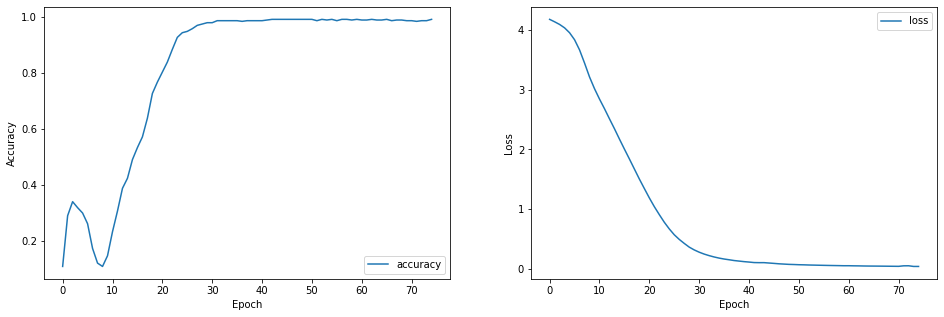

time: 314 ms


In [15]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.plot(epochs_range,history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(122)
plt.plot(epochs_range,history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Saving the model

In [16]:
!pip install -q pyyaml h5py
model.save('/kaggle/working/chatbot8')

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
time: 6.14 s


In [17]:
m = tf.keras.models.load_model('/kaggle/working/chatbot8')
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 420)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                26944     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 66)                2178      
Total params: 31,202
Trainable params: 31,202
Non-trainable params: 0
_________________________________________________________________
time: 227 ms


# Predictions

In [18]:
def bow(sentence, vector, show_details=False):
    
    sentence_words = text_normalization(clean_text(sentence))
    
    bag = [0]*len(vector)  
    for s in sentence_words.split():
        for i,w in enumerate(vector):
            if w == s: 
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

time: 1.48 ms


In [19]:
ERROR_THRESHOLD = 0.25
def classify(sentence):
    sent = pd.DataFrame([bow(sentence,vector=words)],dtype=float,index=['input'])

    results = model.predict([sent])[0]
    results = [[i,r] for i,r in enumerate(results) if r>ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    
    return_list = []
    for r in results:
        return_list.append((tags[r[0]], r[1]))
    
    return return_list

time: 1.88 ms


In [20]:
classify('part of which workgroups')

[('not_in_a_workgroup', 0.9776422)]

time: 105 ms


In [69]:
def predict_response(sentence, show_details=False):
    results = classify(sentence)
    if show_details:
            print('Tag: ',results[0][0])

    if results:
        while results:
            for i in intents_dict['intents']:
                if i['tag'] == results[0][0]:
                    response = random.choice(i['responses'])
                    return response

    else:
        not_known_statements = ['Once again','Try once more','Say once again','Try another way','I did not understand','I did not get that']
        response = random.choice(not_known_statements)
        return response

time: 1.78 ms


In [83]:
text="Working hours"
# classify(text)
predict_response(text)

'Our interns need to only make sure that they are online for 1 hour per day or 7 hours a week.'

time: 61.9 ms


# Interacting with chatbot

In [84]:
def chat():
    print('NATU: Welcome User, I am a chatbot assistant\n')
    while True:
        text = str(input('YOU: '))
        
        if text=='quit':
            print('NATU: ','Bye, See you again soon!','\n')
            break
            
        response = predict_response(text)
        print('NATU: ',response,'\n')

time: 1.15 ms


In [85]:
chat()

NATU: Welcome User, I am a chatbot assistant

YOU: heya
NATU:  Hi there, how can I help? 

YOU: iugiuiugiug
NATU:  Say once again 

YOU: fiyfifififyififiy
NATU:  I did not get that 

YOU: in which workgroups should i be in
NATU:  Every intern should be a part of 2 workgroups.
'202003-IP' -- This is a general workgroup. Everyone who is enrolled in IP should be a part of this workgroup.
'202003-IP-Technology'  -- This is a technology-specific workgroup. You'll be added to the technology you had enrolled for. For example “202003-IP-Python” for students who enrolled for python. If anyone has not been added to any of these workgroups, kindly message “Cloud Counselage HR” regarding the same over bitrix24 platform. 

YOU: quit
NATU:  Bye, See you again soon! 

time: 48.8 s


# THE END